# All Parameters

In [94]:
REFERENCE_MISSION = 2
mission_numbers = [REFERENCE_MISSION, 3, 4, 5, 6, 8, 9, 10, 11]
display_images = False

In [95]:
BBOX_COLOR = (255, 0, 0)

# All Imports

In [96]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import exposure
from skimage.morphology import area_opening, disk, square
import sys

In [97]:
# files


# All Functions

In [98]:
def plot_images(image_list, title_list=[], grid='off', size_per_image=10):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(size_per_image*len(image_list), size_per_image*1))
    if len(image_list) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)

In [99]:
def get_mission_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '\\mission_' + str(mission_number) + '_'

In [100]:
def get_global_image(mission_number, get_normalized=False):
    if get_normalized:
        mission = np.load(get_mission_file_path(mission_number) + 'normalized_image.npy')
    else:
        mission = np.load(get_mission_file_path(mission_number) + 'aligned_image.npy')
    
    return mission

In [101]:
def get_region_and_sample_image(mission_number, region_name, get_normalized=False):
    if get_normalized:
        region = np.load(get_mission_file_path(mission_number) + 'normalized_region_image_' + region_name + '.npy')
        sample = np.load(get_mission_file_path(mission_number) + 'normalized_sample_image_' + region_name + '.npy')
    else:
        region = np.load(get_mission_file_path(mission_number) + 'aligned_region_image_' + region_name + '.npy')
        sample = np.load(get_mission_file_path(mission_number) + 'aligned_sample_image_' + region_name + '.npy')
    
    return region, sample

In [102]:
# BOUNDING BOX

from skimage.measure import label, regionprops

def create_bounding_boxes(masks, output_images, display_bbox=True, display_output=True, num_bbox_iterations=1, bbox_color=(255, 0, 0)):

    temp = copy.deepcopy(masks)
    temp_bounding_box_masks = []

    num_bbox = []
    
    for k in range(0, num_bbox_iterations):
        print('Iter:', k)
        bounding_box_masks = []

        for i in range(0, len(temp)):
            label_ = label(temp[i])
            props_ = regionprops(label_)
            bounding_mask = np.zeros((temp[i].shape)).astype(np.uint8)

            print('# bbox:', len(props_))
            if k == num_bbox_iterations-1:
                num_bbox.append(len(props_))

            factor = 0
            for prop in props_:
        #         print('bbox', prop.bbox)
                if k == num_bbox_iterations-1:
                    cv2.rectangle(bounding_mask, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)
                else:
                    cv2.rectangle(bounding_mask, (prop.bbox[1]-factor, prop.bbox[0]-factor), (prop.bbox[3]+2*factor, prop.bbox[2]+2*factor), bbox_color, 2)

            bounding_box_masks.append(bounding_mask)

        temp_bounding_box_masks.append(copy.deepcopy(bounding_box_masks))
        temp = copy.deepcopy(bounding_box_masks)
    
    if display_bbox:
        for k in range(0, num_bbox_iterations):
            plot_images(temp_bounding_box_masks[k], ['bounding_box_masks ' + str(mission_number) for mission_number in mission_numbers])
    
    results = []
    for i in range(0, len(mission_numbers)):
        result = copy.deepcopy(output_images[i])
        result[temp_bounding_box_masks[num_bbox_iterations-1][i].astype(bool), :] = [0, 0, 255]
        results.append(result)
        
    if display_output:
        # differences wrt mission 2
        for i in range(0, len(mission_numbers)):
            plot_images([histogram_mission_images_bgr[0], results[i]], ['reference', 'result ' + str(mission_numbers[i])], size_per_image=3)
            
    return bounding_box_masks, num_bbox, results

In [103]:
# COLOR GRADIENT

import matplotlib as mpl
from PIL import ImageColor

def color_fader(cs, mix=0):
    if len(cs) == 2:
        c1 = np.array(mpl.colors.to_rgb(cs[0]))
        c2 = np.array(mpl.colors.to_rgb(cs[1]))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
    elif len(cs) == 3:
        c1 = np.array(mpl.colors.to_rgb(cs[0]))
        c2 = np.array(mpl.colors.to_rgb(cs[1]))
        c3 = np.array(mpl.colors.to_rgb(cs[2]))
        if mix <= .5:
            mix *= 2 # create 0-1 range
            return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
        else:
            mix -= .5 # create 0-1 range
            mix *= 2
            return mpl.colors.to_hex((1-mix)*c2 + mix*c3)

def create_color_buckets(colors=['#FF0000', '#00FF00'], num_buckets=10, display=True): #RGB
    color_buckets = []

    if display:
        fig, ax = plt.subplots(figsize=(4, 2))
    
    for x in range(0, num_buckets):
        X = color_fader(colors, x/(num_buckets-1))
        
        if display:
            ax.axvline(x, color=X, linewidth=4)
        
        color_buckets.append(ImageColor.getcolor(X, "RGB")[::-1]) # convert RGB to BGR

    if display:
        plt.axis('off')
        plt.show()

    return color_buckets

In [104]:
# HISTOGRAM MATCHING

# https://automaticaddison.com/how-to-do-histogram-matching-using-opencv/

def calculate_cdf(histogram):
    """
    This method calculates the cumulative distribution function
    :param array histogram: The values of the histogram
    :return: normalized_cdf: The normalized cumulative distribution function
    :rtype: array
    """
    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()
 
    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())
 
    return normalized_cdf
 
def calculate_lookup(new_cdf, ref_cdf):
    """
    This method creates the lookup table
    :param array new_cdf: The cdf for the source image
    :param array ref_cdf: The cdf for the reference image
    :return: lookup_table: The lookup table
    :rtype: array
    """
    lookup_table = np.zeros(256)
    lookup_val = 0
    for new_pixel_val in range(len(new_cdf)):
        lookup_val
        for ref_pixel_val in range(len(ref_cdf)):
            if ref_cdf[ref_pixel_val] >= new_cdf[new_pixel_val]:
                lookup_val = ref_pixel_val
                break
        lookup_table[new_pixel_val] = lookup_val
    return lookup_table

def match_histograms(ref_image, new_image):
    """
    This method matches the new image histogram to the
    reference signal
    :param image new_image: The original source image
    :param image  ref_image: The reference image
    :return: image_after_matching
    :rtype: image (array)
    """
    # Split the images into the different color channels
    # b means blue, g means green and r means red
    new_b, new_g, new_r = cv2.split(new_image)
    ref_b, ref_g, ref_r = cv2.split(ref_image)
 
    # Compute the b, g, and r histograms separately
    # The flatten() Numpy method returns a copy of the array c
    # collapsed into one dimension.
    new_hist_blue, bin_0 = np.histogram(new_b.flatten(), 256, [0,256])
    new_hist_green, bin_1 = np.histogram(new_g.flatten(), 256, [0,256])
    new_hist_red, bin_2 = np.histogram(new_r.flatten(), 256, [0,256])    
    ref_hist_blue, bin_3 = np.histogram(ref_b.flatten(), 256, [0,256])    
    ref_hist_green, bin_4 = np.histogram(ref_g.flatten(), 256, [0,256])
    ref_hist_red, bin_5 = np.histogram(ref_r.flatten(), 256, [0,256])
 
    # Compute the normalized cdf for the source and reference image
    new_cdf_blue = calculate_cdf(new_hist_blue)
    new_cdf_green = calculate_cdf(new_hist_green)
    new_cdf_red = calculate_cdf(new_hist_red)
    ref_cdf_blue = calculate_cdf(ref_hist_blue)
    ref_cdf_green = calculate_cdf(ref_hist_green)
    ref_cdf_red = calculate_cdf(ref_hist_red)

    # Make a separate lookup table for each color
    blue_lookup_table = calculate_lookup(new_cdf_blue, ref_cdf_blue)
    green_lookup_table = calculate_lookup(new_cdf_green, ref_cdf_green)
    red_lookup_table = calculate_lookup(new_cdf_red, ref_cdf_red)
 
    # Use the lookup function to transform the colors of the original
    # source image
    blue_after_transform = cv2.LUT(new_b, blue_lookup_table)
    green_after_transform = cv2.LUT(new_g, green_lookup_table)
    red_after_transform = cv2.LUT(new_r, red_lookup_table)
 
    # Put the image back together
    image_after_matching = cv2.merge([blue_after_transform, green_after_transform, red_after_transform])
    image_after_matching = cv2.convertScaleAbs(image_after_matching)
 
    return image_after_matching

# Load Data

In [105]:
mission_images_bgr = []
grass_images_bgr = []
building_images_bgr = []

for mission_number in mission_numbers:
    if not os.path.isdir('..\\missions\\mission_' + str(mission_number)):
        print('[Error] Mission %d directory has not been created' % (mission_number))
        break
    
    mission_image = get_global_image(mission_number)
    mission_images_bgr.append(mission_image)
    
    grass_image, _ = get_region_and_sample_image(mission_number, 'GRASS')
    grass_images_bgr.append(grass_image)
    building_image, _ = get_region_and_sample_image(mission_number, 'BUILDING')
    building_images_bgr.append(building_image)
    
# all lengths and dimensions should match
print(mission_images_bgr[0].shape)
print(grass_images_bgr[0].shape)
print(building_images_bgr[0].shape)
print(len(mission_images_bgr))
print(len(grass_images_bgr))
print(len(building_images_bgr))

(543, 470, 3)
(543, 470, 3)
(543, 470, 3)
9
9
9


In [106]:
if display_images:
    plot_images(mission_images_bgr, ['mission_images_bgr ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(grass_images_bgr, ['grass_images_bgr ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(building_images_bgr, ['building_images_bgr ' + str(mission_number) for mission_number in mission_numbers])

In [107]:
histogram_mission_images_bgr = []
histogram_grass_images_bgr = []
histogram_building_images_bgr = []

for i in range(0, len(mission_numbers)):
    histogram_mission_images_bgr.append(match_histograms(mission_images_bgr[0], mission_images_bgr[i]))
    histogram_grass_images_bgr.append(match_histograms(grass_images_bgr[0], grass_images_bgr[i]))
    histogram_building_images_bgr.append(match_histograms(building_images_bgr[0], building_images_bgr[i]))

In [108]:
if display_images:
    plot_images(histogram_mission_images_bgr, ['histogram_mission_images_bgr ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(histogram_grass_images_bgr, ['histogram_grass_images_bgr ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(histogram_building_images_bgr, ['histogram_building_images_bgr ' + str(mission_number) for mission_number in mission_numbers])

### grass 6 is messed up

In [109]:
mission_images_hsv = [] # used for shadow detection
histogram_mission_images_hsv = []
histogram_grass_images_hsv = []
histogram_building_images_hsv = []

for i in range(0, len(mission_numbers)):
    hsv = cv2.cvtColor(mission_images_bgr[i].copy(), cv2.COLOR_BGR2HSV)
    mission_images_hsv.append(hsv)
    
    hsv = cv2.cvtColor(histogram_mission_images_bgr[i].copy(), cv2.COLOR_BGR2HSV)
    histogram_mission_images_hsv.append(hsv)
    
    hsv = cv2.cvtColor(histogram_grass_images_bgr[i].copy(), cv2.COLOR_BGR2HSV)
    histogram_grass_images_hsv.append(hsv)
    
    hsv = cv2.cvtColor(histogram_building_images_bgr[i].copy(), cv2.COLOR_BGR2HSV)
    histogram_building_images_hsv.append(hsv)

In [110]:
if display_images:
    plot_images(mission_images_hsv, ['mission_images_hsv ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(histogram_mission_images_hsv, ['histogram_mission_images_hsv ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(histogram_grass_images_hsv, ['histogram_grass_images_hsv ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(histogram_building_images_hsv, ['histogram_building_images_hsv ' + str(mission_number) for mission_number in mission_numbers])

# ^^^^ for all ^^^^

# Shadow

In [111]:
shadow_masks = []
smoothed_shadow_masks = []

for i in range(0, len(mission_numbers)):
    lower_shadow = np.array([69, 20, 1])
    upper_shadow = np.array([129, 102, 34])
    mask = cv2.inRange(mission_images_hsv[i].copy(), lower_shadow, upper_shadow)
    shadow_masks.append(mask)
     
    mask = copy.deepcopy(mask)
    mask = area_opening(mask, area_threshold=50)
    mask = cv2.dilate(mask, disk(radius=5), iterations=1)
    smoothed_shadow_masks.append(mask)
    
complete_shadow_mask = np.zeros((smoothed_shadow_masks[0].shape)).astype(int)
for i in range(0, len(shadow_masks)):
    complete_shadow_mask = cv2.bitwise_or(complete_shadow_mask, smoothed_shadow_masks[i].astype(int))

complete_shadow_mask = complete_shadow_mask.astype(np.uint8)

In [112]:
if display_images:
    plot_images(shadow_masks, ['shadow_masks ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(smoothed_shadow_masks, ['smoothed_shadow_masks ' + str(mission_number) for mission_number in mission_numbers])
    plot_images([complete_shadow_mask], ['complete_shadow_mask'], size_per_image=5)

In [113]:
modified_mission_images_bgr = []
modified_mission_images_hsv = []

for i in range(0, len(mission_numbers)):
    modified_bgr = copy.deepcopy(histogram_mission_images_bgr[i])
    modified_hsv = copy.deepcopy(histogram_mission_images_hsv[i])

    try:
        modified_bgr[complete_shadow_mask.astype(bool), :] = 0 # set to black
        modified_hsv[complete_shadow_mask.astype(bool), :] = 0 # set to black
    except ValueError:
        print('not modified')
    
    modified_mission_images_bgr.append(modified_bgr)
    modified_mission_images_hsv.append(modified_hsv)

In [114]:
if display_images:
    plot_images(modified_mission_images_bgr, ['modified_mission_images_bgr ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(modified_mission_images_hsv, ['modified_mission_images_hsv ' + str(mission_number) for mission_number in mission_numbers])

# Differencing

In [115]:
box_w = 100
box_y = 123

x_lim = np.array([0, int((255-box_w)/2), 255 - int((255-box_w)/2), 255])
y_lim = np.array([0,  box_y, box_y, 255])
z = np.polyfit(x_lim, y_lim, 5)

nonlinear_poly = np.poly1d(z)

xp = np.linspace(0, 255, 256)
yp = nonlinear_poly(xp)

xp_adj = np.linspace(0, 255, 256)
yp_adj = nonlinear_poly(xp_adj)
mask = [num >= x_lim[1] and num <= x_lim[2] for num in xp_adj]
yp_adj[mask] = box_y

C:\Users\alexa\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


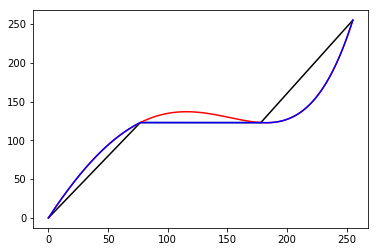

In [116]:
if display:
    plt.plot(x_lim, y_lim, 'k', xp, yp, 'r', xp, yp_adj, 'b')

In [117]:
def detection_methods(img1, img2):
    img1 = copy.deepcopy(img1[:, :, 0]) # using HSV channel
    img2 = copy.deepcopy(img2[:, :, 0])

    img1 = img1.astype(np.int16) # SUPER IMPORTANT - convert to int16 (or higher but necessary) to so that "result" array can preserve greater than +-255
    img2 = img2.astype(np.int16)
    
    result = img1 - img2

    result += 255 # max difference is 255 or -255, add 255 to bring everything positive

    result = (result-np.min(result))*(255/(np.max(result) - np.min(result))) # linear 0-255 scaling

    xp_adj = copy.deepcopy(result)
    yp_adj = nonlinear_poly(xp_adj) # nonlinear 0-255 scaling

    mask = cv2.inRange(xp_adj.copy(), np.array([x_lim[1]]).astype(np.uint8), np.array([x_lim[2]]).astype(np.uint8)).astype(bool)

    result[mask] = box_y
        
    result = result.astype(np.uint8) # convert back to uint8 to be displayed
    
    return result

In [118]:
# using modified_mission_images_hsv[0]

adjacent_regions_change_hsv = []

for i in range(0, len(mission_numbers)):
    adjacent_regions_change_hsv.append(detection_methods(modified_mission_images_hsv[0], modified_mission_images_hsv[i]))
    
masks = []
clean_masks_1 = []
clean_masks_final = []

for i in range(0, len(adjacent_regions_change_hsv)):
    mask = np.bitwise_not(cv2.inRange(adjacent_regions_change_hsv[i].copy(), np.array([box_y - 5]).astype(np.uint8), np.array([box_y + 5]).astype(np.uint8)).astype(bool))
    temp = np.zeros((mask.shape)).astype(np.uint8)
    temp[mask] = 255
    masks.append(temp)
    
    mask = cv2.erode(masks[i], square(width=2), iterations=1) # get rid of small stuff
    clean_masks_1.append(mask)
    mask = cv2.dilate(mask, disk(radius=5), iterations=1)
    clean_masks_final.append(mask)

C:\Users\alexa\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
C:\Users\alexa\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [119]:
if display_images:
    plot_images(adjacent_regions_change_hsv, ['adjacent_regions_change_hsv ' + str(mission_number) for mission_number in mission_numbers])
    plot_images(masks, ['masks ' +  str(mission_number) for mission_number in mission_numbers])
    plot_images(clean_masks_1, ['clean_masks_1' + str(mission_number) for mission_number in mission_numbers])
    plot_images(clean_masks_final, ['clean_masks_final ' + str(mission_number) for mission_number in mission_numbers])

Iter: 0
# bbox: 1
# bbox: 22
# bbox: 21
# bbox: 21
# bbox: 29
# bbox: 35
# bbox: 32
# bbox: 36
# bbox: 34


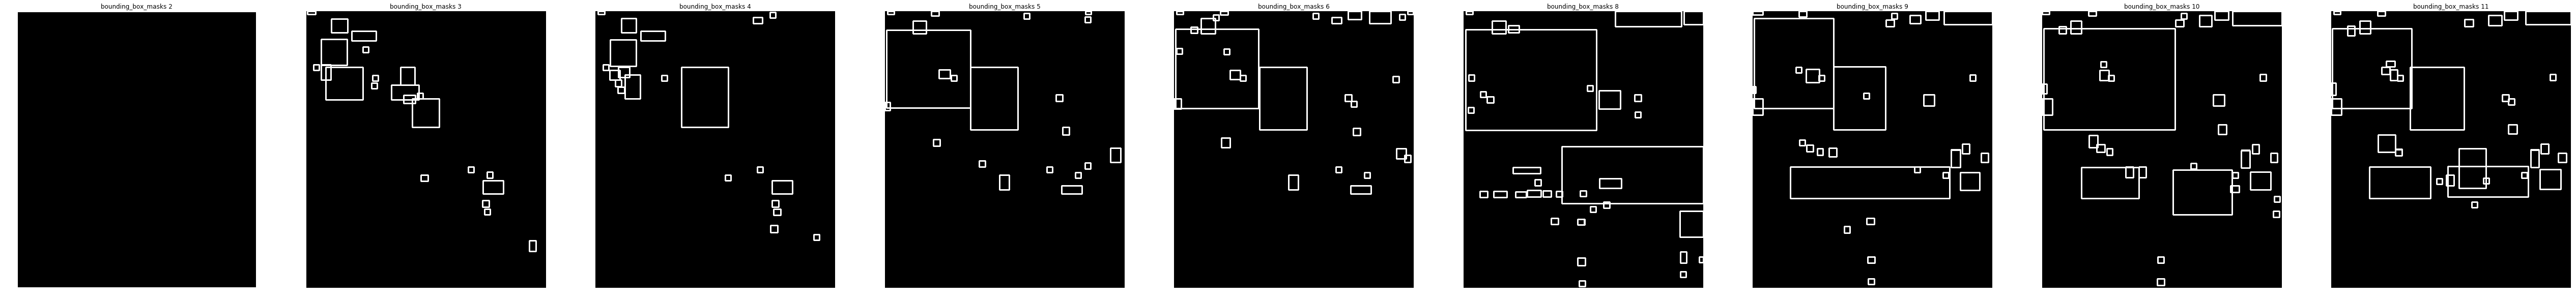

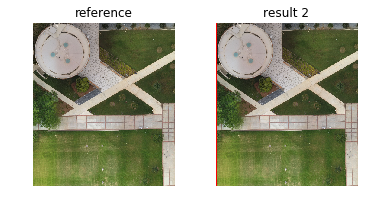

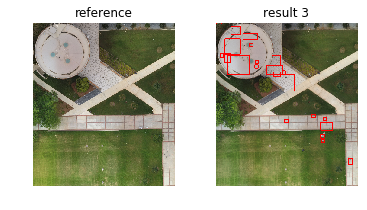

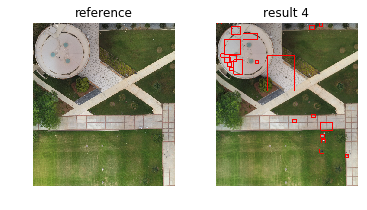

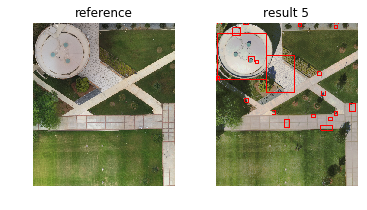

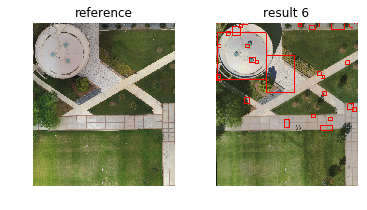

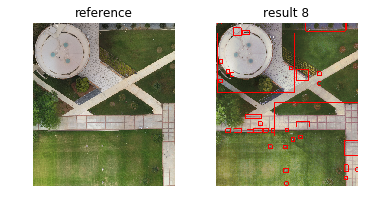

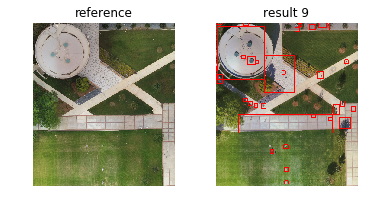

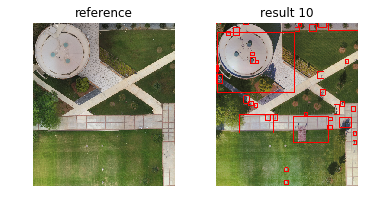

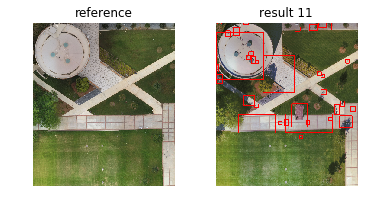

In [120]:
bbox_masks, num_bboxs, superimposed_images = create_bounding_boxes(clean_masks_final, histogram_mission_images_bgr, display_bbox=True, display_output=True, num_bbox_iterations=1, bbox_color=BBOX_COLOR)

### as final output return bbox_masks. these will be superimposed on other bbox_masks, bbox x, y, w, h